In [1]:
!unzip '/content/archive (16).zip' -d '/content/input'

Archive:  /content/archive (16).zip
  inflating: /content/input/dev-v1.1.json  
  inflating: /content/input/train-v1.1.json  


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/input/dev-v1.1.json
/content/input/train-v1.1.json


In [3]:
!pip install evaluate
!pip install rouge_score

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=dd7c5095abb4dc488c78fda22f4a684f2e32eaee8ca16ef13fc31be18ea0c979
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline
from datasets import load_dataset
import evaluate
from tqdm import tqdm

### Download the Base microsoft/DialoGPT-medium Model

In [5]:
# Load the pre-trained microsoft/DialoGPT-medium model and tokenizer
model_name = "microsoft/DialoGPT-medium"
tokenizer_base = GPT2Tokenizer.from_pretrained(model_name)
model_base = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad_token_id to eos_token_id to prevent eos token error
model_base.config.pad_token_id = model_base.config.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Download the fine-tuned models




In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


tokenizer_medium = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model_medium = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")


model_small = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")
tokenizer_small = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")

model_large = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-large")
tokenizer_large = AutoTokenizer.from_pretrained("microsoft/DialoGPT-large")

model_rpt = AutoModelForCausalLM.from_pretrained("microsoft/DialogRPT-updown")
tokenizer_rpt = AutoTokenizer.from_pretrained("microsoft/DialogRPT-updown")

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Load the SQuAD dataset (validation set subset for quick testing)
squad = load_dataset("squad", split="validation[:100]")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [8]:
# Initialize ROUGE evaluator
rouge = evaluate.load("rouge")

In [9]:
# Generate answers for SQuAD dataset
def generate_answers(model, tokenizer, dataset):

    references = []
    predictions = []

    # Initialize a text generation pipeline and set `pad_token_id` to `eos_token_id`
    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        pad_token_id=tokenizer.eos_token_id  # Set pad_token_id here
    )

    for sample in tqdm(dataset, desc="Processing samples"):
        question = sample['question']
        context = sample['context']

        # Create input text combining question and context
        input_text = f"Question: {question} Context: {context} Answer:"

        # Generate the answer from the fine-tuned model with max_new_tokens
        generated_answer = generator(input_text, max_new_tokens=50, num_return_sequences=1)[0]['generated_text']

        # Extract the generated answer (strip the prompt part)
        answer_start_idx = generated_answer.find('Answer:') + len('Answer:')
        predicted_answer = generated_answer[answer_start_idx:].strip()

        # Collect predictions and references
        references.append(sample['answers']['text'][0])  # SQuAD has multiple answers, pick the first one
        predictions.append(predicted_answer)

    return references, predictions

### Calculate ROUGE score for base model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
references_base, predictions_base = generate_answers(model_base, tokenizer_base, squad)

# Compute the ROUGE score between predictions and references
results_base = rouge.compute(predictions=predictions_base, references=references_base)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Processing samples: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


### Calculate ROUGE score for model_small

In [12]:
references_1, predictions_1 = generate_answers(model_small, tokenizer_small, squad)

# Compute the ROUGE score between predictions and references
results_1 = rouge.compute(predictions=predictions_1, references=references_1)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Processing samples: 100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


### Calculate ROUGE score for 2 Epoch model with model_medium

In [13]:
references_2, predictions_2 = generate_answers(model_medium, tokenizer_medium, squad)

# Compute the ROUGE score between predictions and references
results_2 = rouge.compute(predictions=predictions_2, references=references_2)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Processing samples: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


### Calculate ROUGE score for 3 Epoch model with model_large

In [14]:
references_3, predictions_3 = generate_answers(model_large, tokenizer_large, squad)

# Compute the ROUGE score between predictions and references
results_3 = rouge.compute(predictions=predictions_3, references=references_3)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Processing samples: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


In [15]:
references_4, predictions_4 = generate_answers(model_rpt, tokenizer_rpt, squad)

# Compute the ROUGE score between predictions and references
results_4 = rouge.compute(predictions=predictions_4, references=references_4)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Processing samples: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [16]:
# Print the results
print("ROUGE base scores:", results_base)
print()
print("-" * 50)
print()
print("ROUGE 1 Epoch scores:", results_1)
print()
print("-" * 50)
print()
print("ROUGE 2 Epoch scores:", results_2)
print()
print("-" * 50)
print()
print("ROUGE 3 Epoch scores:", results_3)
print("-" * 50)
print()
print("ROUGE 4 Epoch scores:", results_4)

ROUGE base scores: {'rouge1': 0.095, 'rouge2': 0.045, 'rougeL': 0.09833333333333333, 'rougeLsum': 0.09583333333333333}

--------------------------------------------------

ROUGE 1 Epoch scores: {'rouge1': 0.009166666666666667, 'rouge2': 0.005, 'rougeL': 0.0075, 'rougeLsum': 0.009166666666666667}

--------------------------------------------------

ROUGE 2 Epoch scores: {'rouge1': 0.095, 'rouge2': 0.045, 'rougeL': 0.09833333333333333, 'rougeLsum': 0.09583333333333333}

--------------------------------------------------

ROUGE 3 Epoch scores: {'rouge1': 0.08800000000000001, 'rouge2': 0.056666666666666664, 'rougeL': 0.0895, 'rougeLsum': 0.0885}
--------------------------------------------------

ROUGE 4 Epoch scores: {'rouge1': 0.0025, 'rouge2': 0.0, 'rougeL': 0.0025, 'rougeLsum': 0.0025}


### Display ROUGE Scores

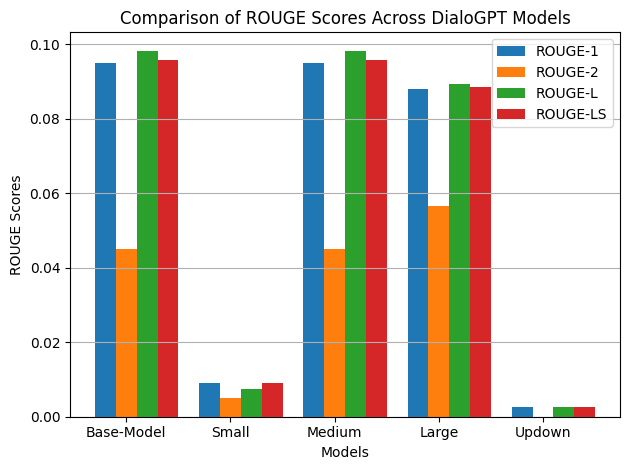

In [24]:
import matplotlib.pyplot as plt
import numpy as np

rouge_results = [results_base, results_1, results_2, results_3, results_4]

# Combine all scores into arrays

rouge_1_scores = [rouge["rouge1"] for rouge in rouge_results]
rouge_2_scores = [rouge["rouge2"] for rouge in rouge_results]
rouge_3_scores = [rouge["rougeL"] for rouge in rouge_results]
rouge_4_scores = [rouge["rougeLsum"] for rouge in rouge_results]

# Labels for each model
labels = ['Base-Model', 'Small', 'Medium', 'Large', 'Updown']

# Create the bar width and positions
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Initialize the plot
fig, ax = plt.subplots()

# Plot each group of ROUGE scores
bars1 = ax.bar(x - width, rouge_1_scores, width, label='ROUGE-1')
bars2 = ax.bar(x, rouge_2_scores, width, label='ROUGE-2')
bars3 = ax.bar(x + width, rouge_3_scores, width, label='ROUGE-L')
bars4 = ax.bar(x + 2 * width, rouge_4_scores, width, label='ROUGE-LS')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('ROUGE Scores')
ax.set_title('Comparison of ROUGE Scores Across DialoGPT Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add a horizontal grid line
ax.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

In [26]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
!pip install google-cloud-storage

In [28]:
from google.colab import auth
auth.authenticate_user()

In [29]:
from google.cloud import storage
import os

# Define the path to your model in Google Drive
drive_model_path = '/content/drive/MyDrive/dialoGPT-finetuned-squad/dialoGPT-finetuned-squad'

# Define your Google Cloud Storage bucket
bucket_name = 'dialogpt-finetuned-squad'
destination_folder = 'models'  # Folder in GCS

# Initialize the GCS client
client = storage.Client()
bucket = client.get_bucket(bucket_name)

# Upload files from Google Drive to GCS
for root, dirs, files in os.walk(drive_model_path):
    for file in files:
        file_path = os.path.join(root, file)
        blob = bucket.blob(os.path.join(destination_folder, file))
        blob.upload_from_filename(file_path)
        print(f"Uploaded {file} to {destination_folder}/{file}")


Uploaded config.json to models/config.json
Uploaded generation_config.json to models/generation_config.json
Uploaded pytorch_model.bin to models/pytorch_model.bin
Uploaded tokenizer_config.json to models/tokenizer_config.json
Uploaded special_tokens_map.json to models/special_tokens_map.json
Uploaded vocab.json to models/vocab.json
Uploaded merges.txt to models/merges.txt
Uploaded training_args.bin to models/training_args.bin
Uploaded config.json to models/config.json
Uploaded generation_config.json to models/generation_config.json
Uploaded pytorch_model.bin to models/pytorch_model.bin
Uploaded tokenizer_config.json to models/tokenizer_config.json
Uploaded special_tokens_map.json to models/special_tokens_map.json
Uploaded vocab.json to models/vocab.json
Uploaded merges.txt to models/merges.txt
Uploaded training_args.bin to models/training_args.bin
Uploaded optimizer.pt to models/optimizer.pt
Uploaded scheduler.pt to models/scheduler.pt
Uploaded rng_state.pth to models/rng_state.pth
Upl